# Heuristics for signals with sparse first and second differences

We can estimate piecewise constant and piecewise linear functions by constructing cost functions that penalize the cardinality of the first- and second-order differences of a signal, respectively. The cardinality measure (sometimes called the $\ell_0$ norm) is simply the number of non-zero values. The $\ell_1$ norm is a common convex relaxation of the cardinality measure. 


Here we demonstrate two signal classes based on the $\ell_1$ heuristic: `SparseFirstDiffConvex` and `SparseSecondDiffConvex`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import GaussNoise, SparseFirstDiffConvex, SparseSecondDiffConvex
from osd.utilities import progress
SOLVER = 'MOSEK'

## Square Plus Triangle

In [3]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
signal1 = signal.square(2 * np.pi * t * 1 / (450.))
signal2 = np.abs(signal.sawtooth(2 * np.pi * t * 1 / (500.)))
y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))

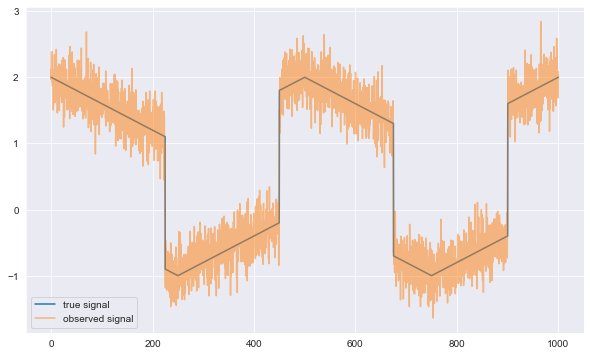

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1 + signal2, label='true signal')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

In [5]:
problem = Problem(data=y, components=[GaussNoise, SparseFirstDiffConvex(vmin=-1, vmax=1),
                                      SparseSecondDiffConvex(vmin=0, vmax=1)])
problem.optimize_weights(solver=SOLVER)
problem.weights.value

IN PROGRESS


array([1., 1., 1.])

In [6]:
problem.weights.value = [1., 3., 1000]
problem.demix(solver=SOLVER)

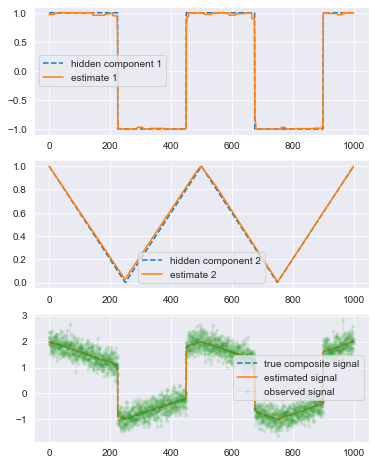

In [7]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.5, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

In [8]:
param_search = np.logspace(-1, 5, 13)
nvals = len(param_search) ** 2
results = pd.DataFrame(columns=['w1', 'w2', 'resid_cost'], index=range(nvals))
counter = 0
for w1 in param_search:
    for w2 in param_search:
        progress(counter, nvals)
        problem.weights.value = [1., w1, w2]
        problem.demix(solver=SOLVER)
        results.loc[counter] = [w1, w2, problem.holdout_validation(solver=SOLVER, seed=42)]
        counter += 1
progress(counter, nvals)

In [9]:
results = results.astype(np.float)

In [10]:
results.loc[results['resid_cost'].idxmin()]

w1              3.162278
w2            316.227766
resid_cost     38.254362
Name: 46, dtype: float64

In [11]:
best = results.loc[results['resid_cost'].idxmin()]
problem.weights.value = [1., best['w1'], best['w2']]
problem.demix(solver=SOLVER)

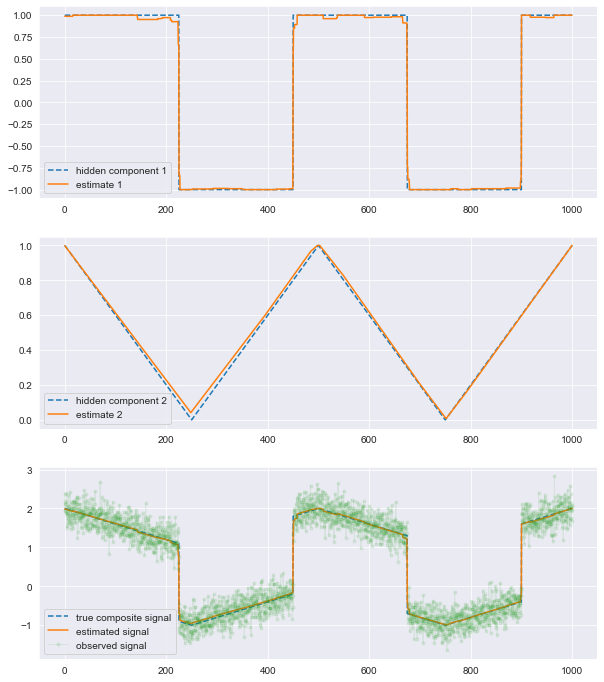

In [12]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 12))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()